In [37]:
#most positive, most negative, largest range, biggest reversal

# Load necessary libraries
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [39]:
file_path = os.path.join(os.getcwd(), "data", "data.xlsm")

try:
    # Read each sheet into a DataFrame
    mimic3d_df = pd.read_excel(file_path, sheet_name='mimic3d', engine='openpyxl')
    sheet2_df = pd.read_excel(file_path, sheet_name='Sheet2', engine='openpyxl')

except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except ValueError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"An error occurred: {e}")

c:\Users\pecko\anaconda3\envs\data-analytics\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Web Extension extension is not supported and will be removed
  for idx, row in parser.parse():


In [40]:
mimic3d_df

hadm_id gender  Gender  age   Age group  age.1  Adult   Teen  \
0       100001      F       1   35       Adult      1       1     0   
1       100003      M       0   59      Senior      4       0     0   
2       100006      F       1   48  Middle Age      3       0     0   
3       100007      F       1   73      Senior      4       0     0   
4       100009      M       0   60      Senior      4       0     0   
...        ...    ...     ...  ...         ...    ...     ...   ...   
58971   199993      M       0   60      Senior      4       0     0   
58972   199994      F       1   58      Senior      4       0     0   
58973   199995      M       0   23       Adult      1       1     0   
58974   199998      M       0   69      Senior      4       0     0   
58975   199999      M       0   88      Senior      4       0     0   

       Middle Age   Child   ...  NumMicroLabs  NumNotes NumOutput  NumRx  \
0                0       0  ...          0.65      0.05      5.19  14.91   
1                0       0  ...          1.24      1.59      5.45   7.18   
2                1       0  ...          0.33      0.15      4.15   6.23   
3                0       0  ...          0.69      0.17      9.05  11.52   
4                0       0  ...          0.61      0.34     16.19  25.00   
...            ...     ...  ...           ...       ...       ...    ...   
58971            0       0  ...          0.20      0.13     23.11   8.01   
58972            0       0  ...          2.26      0.30      7.90   0.00   
58973            0       0  ...          0.54      0.10      6.27   5.79   
58974            0       0  ...          0.17      0.35     12.24  17.69   
58975            0       0  ...          1.64      0.40      4.73   5.82   

       NumProcEvents  NumTransfers  NumChartEvents  ExpiredHospital  \
0               1.13          0.65          398.70                0   
1               0.99          1.24          373.02                0   
2               0.00          0.33          286.21                0   
3               0.00          0.96          526.06                0   
4               2.87          2.05          554.92                0   
...              ...           ...             ...              ...   
58971           0.00          0.08         1315.46                0   
58972           0.00          0.31          674.05                0   
58973           0.00          0.36          207.10                0   
58974           0.00          1.02          426.87                0   
58975           0.55          0.73          550.36                0   

      TotalNumInteract LOSgroupNum  
0               493.89           1  
1               465.71           1  
2               344.00           3  
3               603.05           1  
4               679.84           1  
...                ...         ...  
58971          1746.31           3  
58972           834.98           2  
58973           261.30           3  
58974           537.42           1  
58975           614.59           1  

[58976 rows x 42 columns]

In [41]:
mimic3d_df = mimic3d_df.drop(columns=['hadm_id', 'gender', 'Age group', 'age'])

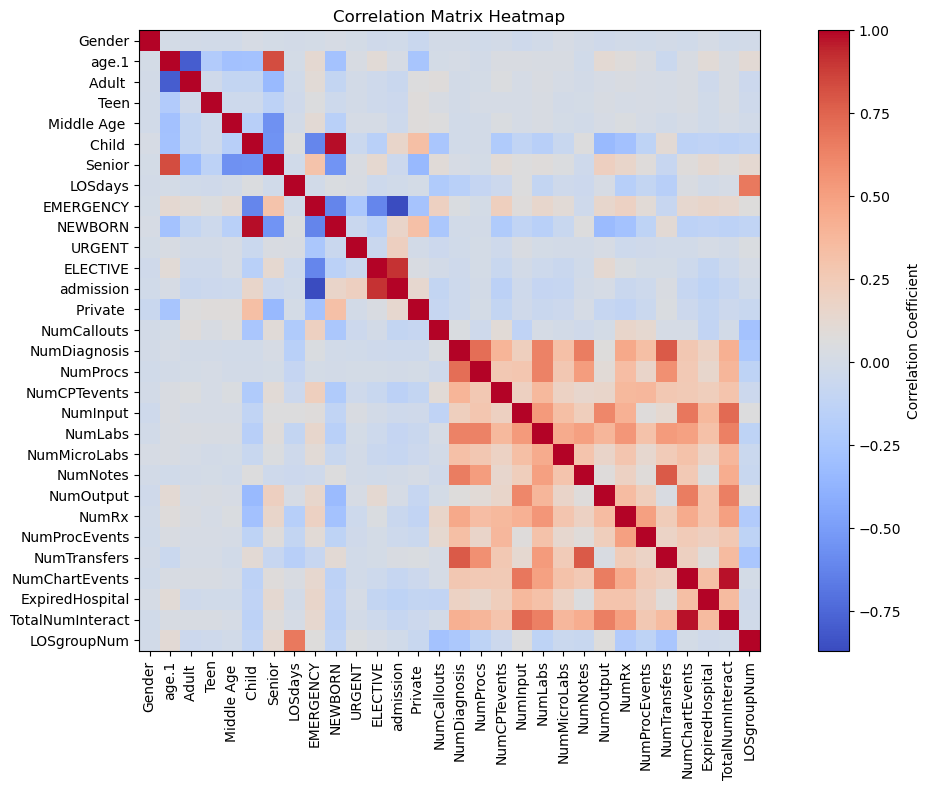

In [42]:
# Select only numeric columns
numeric_df = mimic3d_df.select_dtypes(include=['float64', 'int64', 'boolean'])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Optional: Visualize the correlation matrix
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar(label='Correlation Coefficient')
plt.title('Correlation Matrix Heatmap')
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.tight_layout()
plt.show()

In [45]:
mimic3d_df.columns.tolist()

['Gender',
 'age.1',
 'Adult ',
 'Teen',
 'Middle Age ',
 'Child ',
 'Senior',
 'LOSdays',
 'EMERGENCY',
 'NEWBORN',
 'URGENT',
 'ELECTIVE',
 'admission',
 'AdmitDiagnosis',
 'Private ',
 'NumCallouts',
 'NumDiagnosis',
 'NumProcs',
 'AdmitProcedure',
 'NumCPTevents',
 'NumInput',
 'NumLabs',
 'NumMicroLabs',
 'NumNotes',
 'NumOutput',
 'NumRx',
 'NumProcEvents',
 'NumTransfers',
 'NumChartEvents',
 'ExpiredHospital',
 'TotalNumInteract',
 'LOSgroupNum',
 'insurance_Medicaid',
 'insurance_Medicare',
 'insurance_Private',
 'insurance_Self Pay',
 'religion_BAPTIST',
 'religion_BUDDHIST',
 'religion_CATHOLIC',
 'religion_CHRISTIAN SCIENTIST',
 'religion_EPISCOPALIAN',
 'religion_GREEK ORTHODOX',
 'religion_HEBREW',
 'religion_HINDU',
 "religion_JEHOVAH'S WITNESS",
 'religion_JEWISH',
 'religion_LUTHERAN',
 'religion_METHODIST',
 'religion_MUSLIM',
 'religion_NOT SPECIFIED',
 'religion_OTHER',
 'religion_PROTESTANT QUAKER',
 'religion_ROMANIAN EAST. ORTH',
 'religion_UNITARIAN-UNIVERSALIST

In [44]:
# 1. One-Hot Encoding for Nominal Categorical Variables
one_hot_columns = ["insurance", "religion", "marital_status", "ethnicity", "admit_location", "admit_type"]
mimic3d_df = pd.get_dummies(mimic3d_df, columns=one_hot_columns, drop_first=True)

# 2. Label Encoding for Ordinal Categorical Variables
label_encoder = LabelEncoder()
ordinal_columns = ["Age group"]
for col in ordinal_columns:
    mimic3d_df[col] = label_encoder.fit_transform(mimic3d_df[col])

# 3. TF-IDF Encoding for Text-Heavy Columns
tfidf_columns = ["AdmitProcedure", "AdmitDiagnosis"]
for col in tfidf_columns:
    tfidf = TfidfVectorizer(max_features=50)  # Limit features to 50 for simplicity
    tfidf_matrix = tfidf.fit_transform(mimic3d_df[col].fillna("na"))
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=[f"{col}_{i}" for i in range(50)])
    mimic3d_df = pd.concat([mimic3d_df.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)
    mimic3d_df.drop(columns=[col], inplace=True)

KeyError: "None of [Index(['insurance', 'religion', 'marital_status', 'ethnicity',\n       'admit_location', 'admit_type'],\n      dtype='object')] are in the [columns]"

In [46]:
mimic3d_df.columns.tolist()

['Gender',
 'age.1',
 'Adult ',
 'Teen',
 'Middle Age ',
 'Child ',
 'Senior',
 'LOSdays',
 'EMERGENCY',
 'NEWBORN',
 'URGENT',
 'ELECTIVE',
 'admission',
 'AdmitDiagnosis',
 'Private ',
 'NumCallouts',
 'NumDiagnosis',
 'NumProcs',
 'AdmitProcedure',
 'NumCPTevents',
 'NumInput',
 'NumLabs',
 'NumMicroLabs',
 'NumNotes',
 'NumOutput',
 'NumRx',
 'NumProcEvents',
 'NumTransfers',
 'NumChartEvents',
 'ExpiredHospital',
 'TotalNumInteract',
 'LOSgroupNum',
 'insurance_Medicaid',
 'insurance_Medicare',
 'insurance_Private',
 'insurance_Self Pay',
 'religion_BAPTIST',
 'religion_BUDDHIST',
 'religion_CATHOLIC',
 'religion_CHRISTIAN SCIENTIST',
 'religion_EPISCOPALIAN',
 'religion_GREEK ORTHODOX',
 'religion_HEBREW',
 'religion_HINDU',
 "religion_JEHOVAH'S WITNESS",
 'religion_JEWISH',
 'religion_LUTHERAN',
 'religion_METHODIST',
 'religion_MUSLIM',
 'religion_NOT SPECIFIED',
 'religion_OTHER',
 'religion_PROTESTANT QUAKER',
 'religion_ROMANIAN EAST. ORTH',
 'religion_UNITARIAN-UNIVERSALIST

In [48]:
# Prepare data
target = 'LOSgroupNum'
predictors = mimic3d_df.drop(columns=[target])  # Drop target and ID column

# Convert categorical variables to dummy variables (one-hot encoding)
predictors = pd.get_dummies(predictors, drop_first=True)

# Handle missing values
predictors = predictors.fillna(0)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(predictors, mimic3d_df[target], test_size=0.2, random_state=42)



In [56]:
X_train.describe()

Gender         age.1        Adult           Teen   Middle Age   \
count  47180.000000  47180.000000  47180.000000  47180.000000  47180.000000   
mean       0.441543      3.536456      0.054748      0.010068      0.140504   
std        0.496576      0.772856      0.227490      0.099833      0.347513   
min        0.000000      1.000000      0.000000      0.000000      0.000000   
25%        0.000000      3.000000      0.000000      0.000000      0.000000   
50%        0.000000      4.000000      0.000000      0.000000      0.000000   
75%        1.000000      4.000000      0.000000      0.000000      0.000000   
max        1.000000      4.000000      1.000000      1.000000      1.000000   

             Child         Senior       LOSdays     EMERGENCY       NEWBORN  \
count  47180.000000  47180.000000  47180.000000  47180.000000  47180.000000   
mean       0.138660      0.656019     10.163434      0.713396      0.134294   
std        0.345596      0.475040     12.587438      0.452180      0.340972   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      3.750000      0.000000      0.000000   
50%        0.000000      1.000000      6.420000      1.000000      0.000000   
75%        0.000000      1.000000     11.830000      1.000000      0.000000   
max        1.000000      1.000000    206.420000      1.000000      1.000000   

       ...  AdmitProcedure_Vertebral fx repair  \
count  ...                        47180.000000   
mean   ...                            0.000911   
std    ...                            0.030176   
min    ...                            0.000000   
25%    ...                            0.000000   
50%    ...                            0.000000   
75%    ...                            0.000000   
max    ...                            1.000000   

       AdmitProcedure_Vesic fistula repair NEC  \
count                             47180.000000   
mean                                  0.000021   
std                                   0.004604   
min                                   0.000000   
25%                                   0.000000   
50%                                   0.000000   
75%                                   0.000000   
max                                   1.000000   

       AdmitProcedure_Vessel operation NEC  \
count                         47180.000000   
mean                              0.000021   
std                               0.004604   
min                               0.000000   
25%                               0.000000   
50%                               0.000000   
75%                               0.000000   
max                               1.000000   

       AdmitProcedure_Video/radio eeg monitor  \
count                            47180.000000   
mean                                 0.000382   
std                                  0.019529   
min                                  0.000000   
25%                                  0.000000   
50%                                  0.000000   
75%                                  0.000000   
max                                  1.000000   

       AdmitProcedure_Vitreous operation NEC  \
count                           47180.000000   
mean                                0.000021   
std                                 0.004604   
min                                 0.000000   
25%                                 0.000000   
50%                                 0.000000   
75%                                 0.000000   
max                                 1.000000   

       AdmitProcedure_Whole blood transfus NEC  \
count                             47180.000000   
mean                                  0.000021   
std                                   0.004604   
min                                   0.000000   
25%                                   0.000000   
50%                                   0.000000   
75%                                   0.000000 

In [50]:
# Convert boolean columns to integers
X_train = X_train.astype(float)
X_test = X_test.astype(float)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

# Define the linear regression model
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)  # One output for regression

    def forward(self, x):
        return self.linear(x)

input_dim = X_train.shape[1]
model = LinearRegressionModel(input_dim).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
epochs = 1000
for epoch in range(epochs):
    model.train()
    
    # Forward pass
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    y_pred = y_pred_tensor.cpu().numpy()

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nLinear Regression Metrics:")
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")


Gender                                     float64
age.1                                      float64
Adult                                      float64
Teen                                       float64
Middle Age                                 float64
                                            ...   
AdmitProcedure_Whole blood transfus NEC    float64
AdmitProcedure_Wide excision of lip les    float64
AdmitProcedure_Wound irrigation NEC        float64
AdmitProcedure_Wrist synovectomy           float64
AdmitProcedure_na                          float64
Length: 17065, dtype: object
Epoch [100/1000], Loss: nan
Epoch [200/1000], Loss: nan
Epoch [300/1000], Loss: nan
Epoch [400/1000], Loss: nan
Epoch [500/1000], Loss: nan
Epoch [600/1000], Loss: nan
Epoch [700/1000], Loss: nan
Epoch [800/1000], Loss: nan
Epoch [900/1000], Loss: nan
Epoch [1000/1000], Loss: nan


ValueError: Input contains NaN.